<a href="https://colab.research.google.com/github/Balan666/BI_ML_2023/blob/Ensembles/Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [ ]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

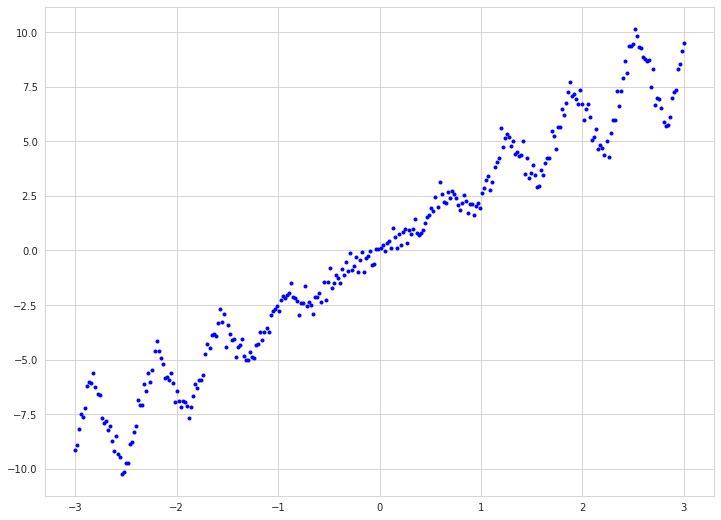

In [ ]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [ ]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

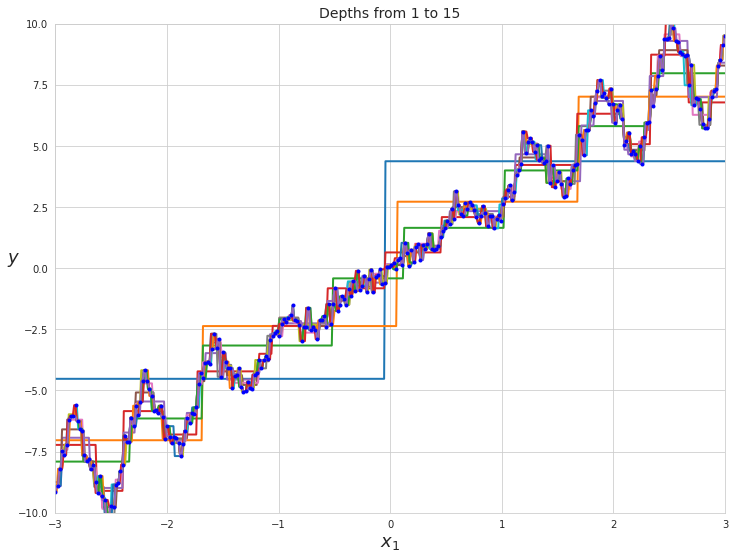

In [ ]:
plt.figure(figsize=(12, 9))
for i in range(1, 16):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
  clf = DecisionTreeRegressor(max_depth=i, random_state=i)
  clf.fit(X_train, y_train)
  plot_regression_predictions(clf, X, y)
plt.title("Depths from 1 to 15", fontsize=14)
plt.plot(X.reshape(-1), y.reshape(-1), "b.");
plt.show()

**Сложно разглядеть, сделаем по-другому:**

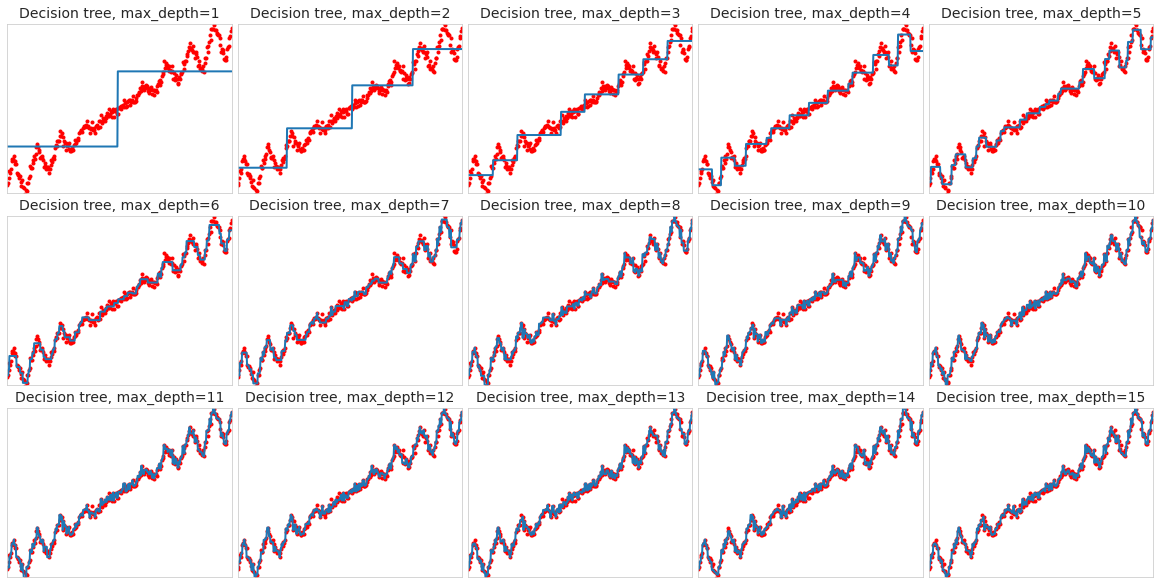

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(16, 8), layout="constrained")
for i in range(1, 16):
  plt.subplot(3, 5, i)
  plt.plot(X.reshape(-1), y.reshape(-1), "r.");
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
  clf = DecisionTreeRegressor(max_depth=i, random_state=i)
  clf.fit(X_train, y_train)
  plot_regression_predictions(clf, X_test, y_test)
  plt.xticks([], [])
  plt.yticks([], [])
  plt.title(f'Decision tree, max_depth={i}', fontsize=14)
  plt.xlabel("")
  plt.ylabel("")
  plt.xticks([], [])
  plt.yticks([], [])

**Видно, что в целом дерево уже начиная с максимальной глубины в 7-8 справляется хорошо. Можно взять 8 или 9, на этой максимальной глубине bias уже достаточно мал. При большей глубине дерево будет переобучаться и variance возрастет.**

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

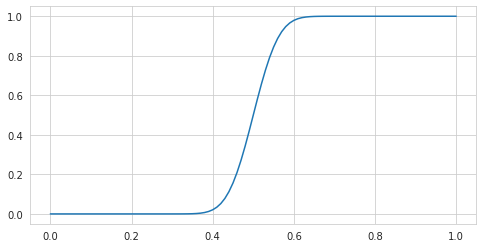

In [ ]:
t = np.arange(0.0, 1.01, 0.01)
s = 0
for i in range(51, 102):
  s+= np.math.factorial(101)/(np.math.factorial(i)*np.math.factorial(101-i))*(t**i)*(1 - t)**(101 - i)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, s)

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

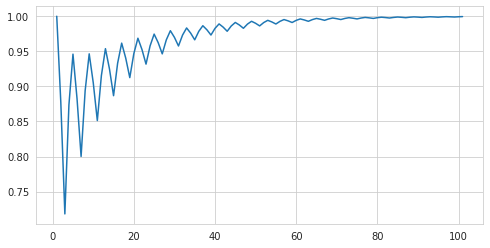

In [ ]:
prob = []
model_num = np.arange(1, 102)
for m in model_num:
  s = 0
  for i in range(int(np.round(m/2)), m+1):
    s+= np.math.factorial(m)/(np.math.factorial(i)*np.math.factorial(m-i))*(0.65**i)*((1 - 0.65)**(m - i))
  prob.append(s)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(model_num, prob)

Я не очень понимаю, почему он такой странный, я просто пыталась по формуле....

Опишите ваши наблюдения:

* Чтобы правильно предсказать результат по числу голосов 101 классификатора нам нужно, чтобы точность каждого была минимум 0.63 (примерно)
* Если взять точность каждого 0.65, то на самом деле можно взять и поменьше классификаторов, не 101, а 90 (примерно)

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [ ]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        assert n_samples == y.shape[0], "Size of X and y do not match"
        self.trees = []
        self.feat_ids_by_tree = []
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(n_features, size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)
            sample_ids = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[sample_ids] #[:, feat_ids]
            y_sample = y[sample_ids]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))
        '''
        for feat_ids, tree in zip(self.feat_ids_by_tree, self.trees):
            X_subset = X[:, feat_ids]
            probas += tree.predict_proba(X_subset)
        '''
        for tree in self.trees:
            probas += tree.predict_proba(X)
        probas /= len(self.trees)
        return probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

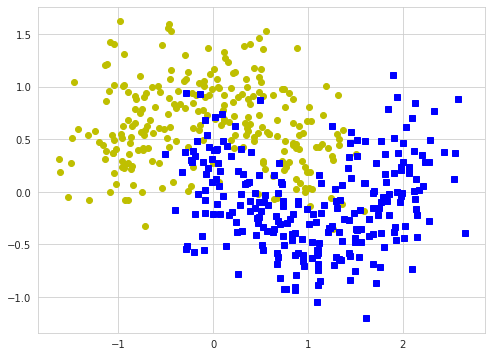

In [ ]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

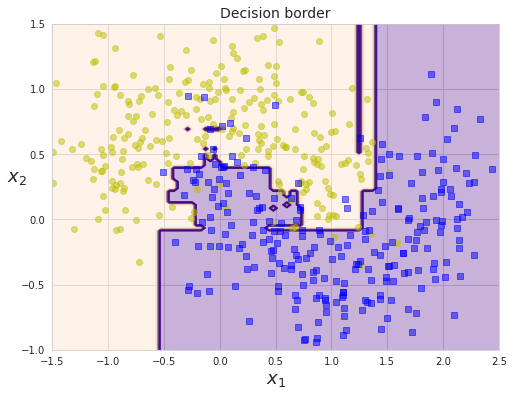

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
rfcc = RandomForestClassifierCustom(max_depth=20, random_state=42)
rfcc.fit(X_train, y_train)

plot_decision_boundary(rfcc, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

([], [])

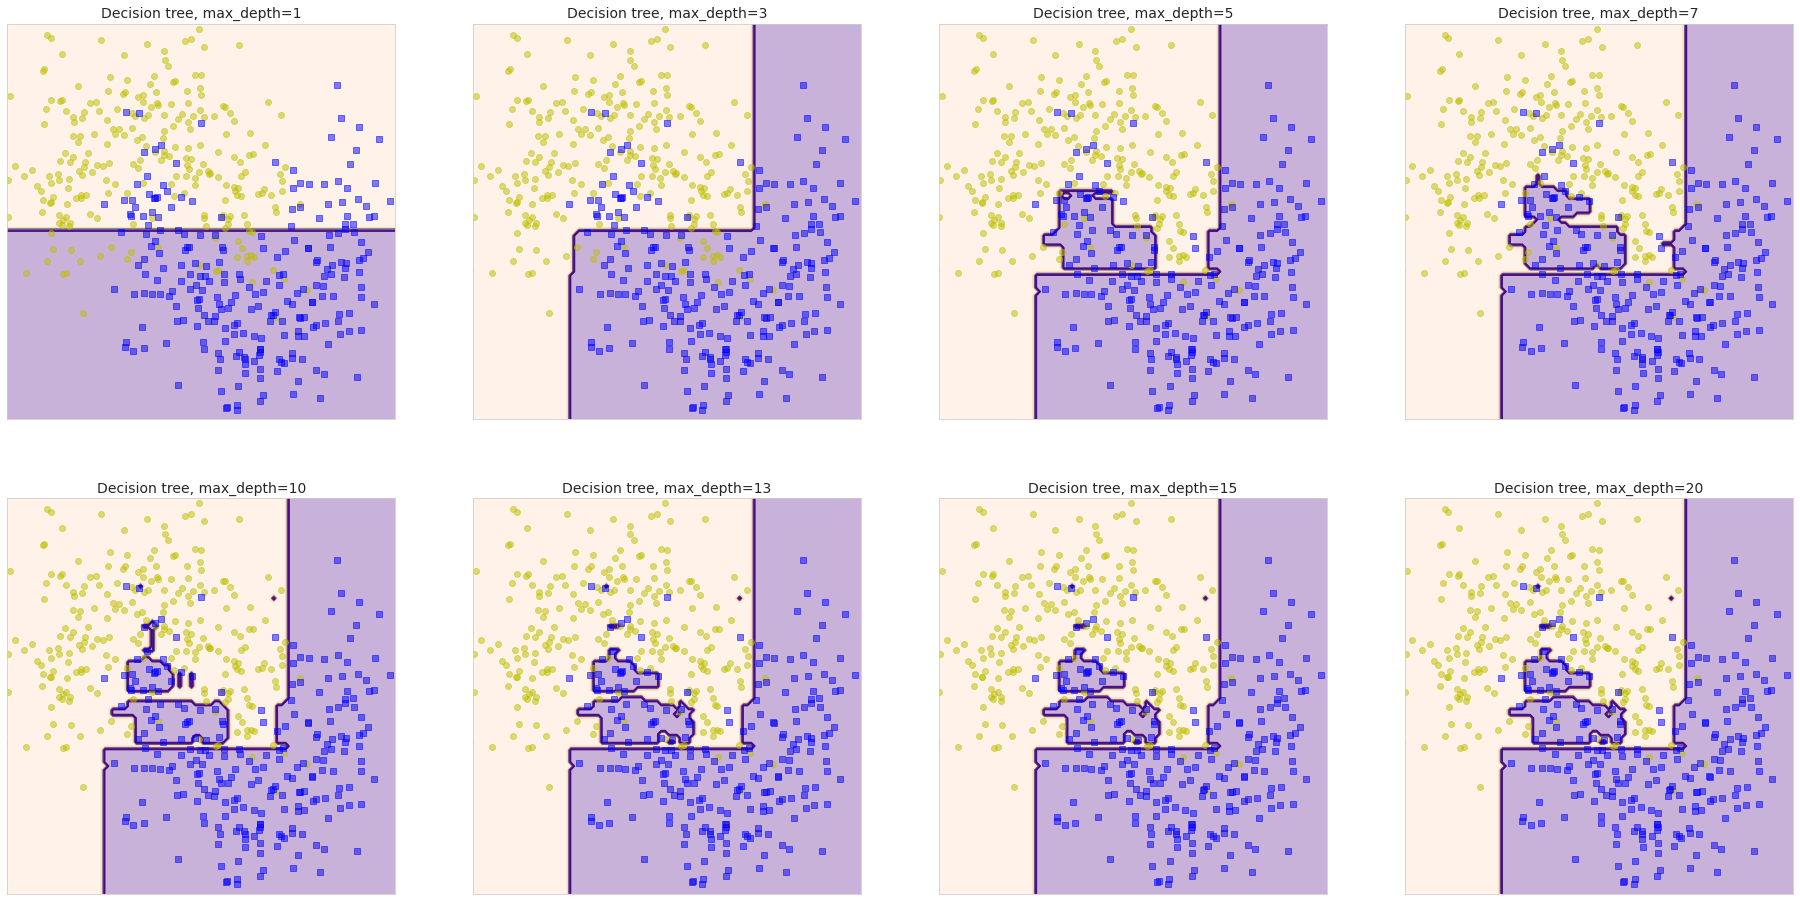

In [ ]:
plt.figure(figsize=(32, 16))

plt.subplot(241)
dt1 = RandomForestClassifierCustom(max_depth=1)
dt1.fit(X_train, y_train)
plot_decision_boundary(dt1, X, y)
plt.xticks([], [])
plt.yticks([], [])
plt.title("Decision tree, max_depth=1", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(242)
dt3 = RandomForestClassifierCustom(max_depth=3)
dt3.fit(X_train, y_train)
plot_decision_boundary(dt3, X, y)
plt.title("Decision tree, max_depth=3", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(243)
dt5 = RandomForestClassifierCustom(max_depth=5)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=5", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(244)
dt5 = RandomForestClassifierCustom(max_depth=7)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=7", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(245)
dt5 = RandomForestClassifierCustom(max_depth=10)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=10", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(246)
dt5 = RandomForestClassifierCustom(max_depth=13)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=13", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(247)
dt5 = RandomForestClassifierCustom(max_depth=15)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=15", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(248)
dt5 = RandomForestClassifierCustom(max_depth=20)
dt5.fit(X_train, y_train)
plot_decision_boundary(dt5, X, y)
plt.title("Decision tree, max_depth=20", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks([], [])
plt.yticks([], [])

Не подключая метрики можно сказать, что глубины примерно 7 достаточно.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [ ]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [ ]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
%%timeit
i=0
corrs = []
for max_f in [1, 3, 5, 7, 9, 11, 13, None, "log2", "auto", "sqrt"]:
  rfc = RandomForestClassifier(max_depth = 10, max_features=max_f,random_state=i)
  rfc.fit(X_train, y_train)
  rfc.predict(X_test)
  corrs.append(base_model_pair_correlation(rfc, X_test))
  i+=1

1min 18s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


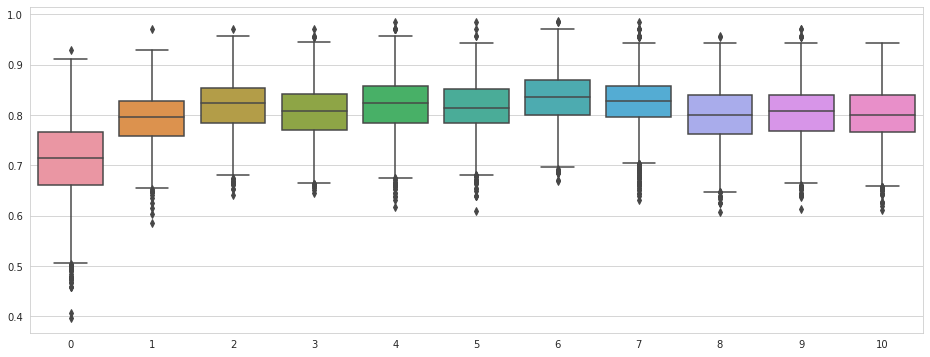

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(corrs)
plt.show()

Далее показатели будут только расти, если увеличивать число Max_features:

In [ ]:
corrs = []

rfc = RandomForestClassifier(max_depth = 5, max_features=3,random_state=0)
rfc.fit(X_train, y_train)
corrs.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 5, max_features=10,random_state=3)
rfc.fit(X_train, y_train)
corrs.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 5, max_features=15,random_state=6)
rfc.fit(X_train, y_train)
corrs.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 5, max_features=30,random_state=10)
rfc.fit(X_train, y_train)
corrs.append(base_model_pair_correlation(rfc, X_test))

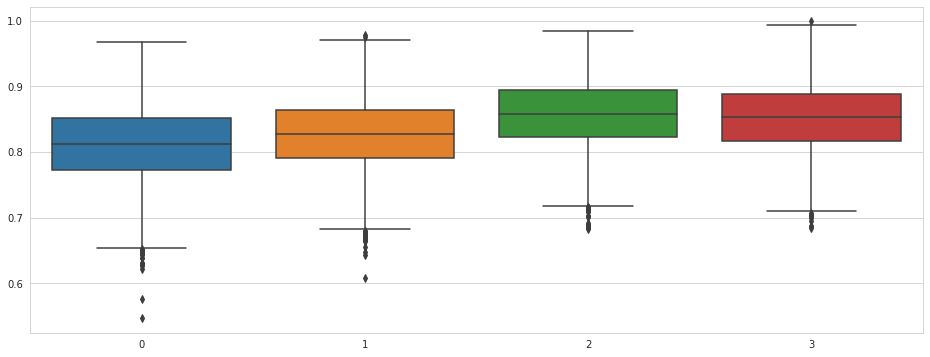

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(corrs)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
%%timeit
i=0
corrs_depth = []
for max_depth in [1, 3, 5, 10, 15, 20, 30, None]:
  rfc = RandomForestClassifier(max_depth = max_depth,random_state=i)
  rfc.fit(X_train, y_train)
  rfc.predict(X_test)
  corrs_depth.append(base_model_pair_correlation(rfc, X_test))
  i+=1

54.9 s ± 586 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
corrs_depth = []

rfc = RandomForestClassifier(max_depth = 1,random_state=8)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 3,random_state=0)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 5,random_state=1)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 7,random_state=2)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 10,random_state=3)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 15,random_state=4)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 20,random_state=5)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 25,random_state=6)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

rfc = RandomForestClassifier(max_depth = 30,random_state=7)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

In [ ]:
rfc = RandomForestClassifier(max_depth = 50,random_state=9)
rfc.fit(X_train, y_train)
corrs_depth.append(base_model_pair_correlation(rfc, X_test))

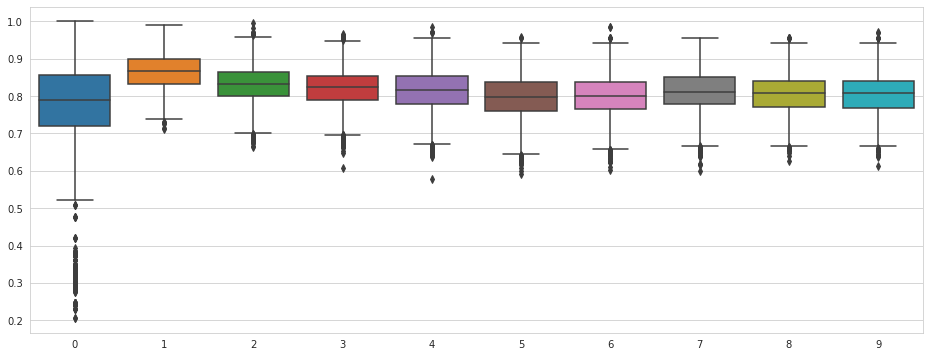

In [ ]:
#labels =["1", "3", "5", "7", "10", "15", "20", "25", "30"]
plt.figure(figsize=(16, 6))
sns.boxplot(corrs_depth)
plt.show()

Опишите ваши наблюдения:

* Чем больше max_feature, тем больше будет корреляция. Можно взять 3-5 черт. Режимы auto, log2 и sqrt это почти одно и то же (на данной выборке они, вроде, должны совпадать со значением 5, примерно так и вышло)
* При изменении максимальной глубины корреляция уменьшалась до значения 15-20, а затем возрастала.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [ ]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
etc.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
cat.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
lgbm_rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
xgb_rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
nb.fit(X_train, y_train)
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8129461544095692
XGBRFClassifier: 0.8426829268292683
LGBMClassifier: 0.8101597492003888
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8395804737268152
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
for model in [dt, rf, etc, knn, svc_lin, svc_rbf, cat, lgbm, lgbm_rf, xgb, xgb_rf, lr, nb]:
  print(base_model_pair_correlation_for_voting_clf(model, X_train))

In [ ]:
new_models = [("DT", dt),("KNN", knn), 
               ("SVC_LIN", svc_lin), 
               ("XGB", xgb), ("LR", lr)]

voting_hard = VotingClassifier(estimators=new_models, voting='hard')
voting_hard.fit(X_train,y_train)

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('KNN', KNeighborsClassifier(weights='distance')),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytr...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=111, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear'))])

In [ ]:
cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1").mean()

0.8680476611511093

я пытался, честно! (╥﹏╥) Это лучшее, что у меня получилось

In [ ]:
new_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [ ]:
new_models = [("DT", dt), 
               ("SVC_LIN", svc_lin), 
               ("XGB_RF", xgb_rf), ("LR", lr)]

voting_hard = VotingClassifier(estimators=new_models, voting='soft')
voting_hard.fit(X_train,y_train)

VotingClassifier(estimators=[('DT',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=10,
                                                     random_state=111)),
                             ('SVC_LIN',
                              SVC(kernel='linear', probability=True,
                                  random_state=111)),
                             ('XGB_RF',
                              XGBRFClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_m...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='binary:logistic',
                                              predictor=None, random_state=111,
                                              reg_alpha=None, ...)),
                             ('LR',
                              LogisticRegression(max_iter=10000,
                                                 solver='liblinear'))],
                 voting='soft')

In [ ]:
cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1").mean()

0.8419730761502913

In [ ]:
base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

In [ ]:
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8129461544095692
XGBRFClassifier: 0.8426829268292683
LGBMClassifier: 0.8101597492003888
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8423036460062613
VotingClassifier: 0.8503633581946834


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [ ]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [ ]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Явных выбросов нет, пропущенных значений нет

Заменим неудобные названия

In [ ]:
churn_df=data.rename(columns={"Int'l Plan":"Intl Plan"})
churn_df=churn_df.rename(columns={'Churn?':'Churn'})

Заменим текстовые 'false'/'true' на 0 и 1

In [ ]:
churn_df['Churn']=churn_df['Churn'].apply(lambda x:1 if x=="True." else 0 )
churn_df['Intl Plan']=churn_df['Intl Plan'].apply(lambda x:1 if x=="yes" else 0 )
churn_df['VMail Plan']=churn_df['VMail Plan'].apply(lambda x:1 if x=="yes" else 0 )

Не будем учитывать тф номера и их коды, а также штат. Можно еще как в первых дз сделать их OneHotEncoder'ом

In [ ]:
churn_df_dropped=churn_df.drop(['State','Area Code','Phone'],axis=1)

In [ ]:
X=churn_df_dropped.drop(columns=['Churn'])
y=churn_df_dropped[['Churn']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=SEED)

**lightgbm.LGBMClassifier** 

На базовых настройках:

In [ ]:
LGBMC = lightgbm.LGBMClassifier()
LGBMC.fit(X_train, y_train)
y_pred = LGBMC.predict(X_test)

In [ ]:
from sklearn import metrics

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9580209895052474

На доп настройках:

For Better Accuracy:

Use large max_bin (may be slower)

Use small learning_rate with large num_iterations

Use large num_leaves (may cause over-fitting)

Use bigger training data

Try dart


Deal with Over-fitting:

* Use small max_bin
* Use small num_leaves

* Use min_data_in_leaf and min_sum_hessian_in_leaf

* Use bagging by set bagging_fraction and bagging_freq

* Use feature sub-sampling by set feature_fraction

* Use bigger training data

* Try lambda_l1, lambda_l2 and min_gain_to_split for regularization

* Try max_depth to avoid growing deep tree

* Try extra_trees

* Try increasing path_smooth

In [ ]:
LGBMC_plus = lightgbm.LGBMClassifier(boosting_type='dart', num_leaves=11, max_depth=-1, 
                                learning_rate=0.1, n_estimators=200, subsample_for_bin=100000, 
                                objective=None, class_weight=None, min_split_gain=0.0, 
                                min_child_weight=0.1, min_child_samples=20, subsample=1.0, 
                                subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, 
                                reg_lambda=0.0, random_state=None, n_jobs=None, 
                                importance_type='split')
LGBMC_plus.fit(X_train, y_train)
y_pred = LGBMC_plus.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9625187406296851

**Лес!**

In [ ]:
LGBMCRF = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.001)
LGBMCRF.fit(X_train, y_train)
y_pred_rf = LGBMCRF.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.001


In [ ]:
metrics.accuracy_score(y_test, y_pred_rf)

0.8590704647676162

Блин, тут у меня прям никак не получается повысить accuracy.... Много чего перепробовала, бестолку

**Попробуем теперь другие, чтобы сравнить**

In [ ]:
cat = catboost.CatBoostClassifier()
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9580209895052474

Хорошо, что мы не использовали one hot encoder, на сайте написано, что это негативно влияет на точность

In [ ]:
cat = catboost.CatBoostClassifier(depth=6, learning_rate=0.009, l2_leaf_reg=10, random_strength=0.5, iterations=600)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.95952023988006

In [ ]:
cat = catboost.CatBoostClassifier(depth=6, iterations=600, learning_rate=0.05, l2_leaf_reg=3, random_strength=0.4, bagging_temperature=0.3)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9580209895052474

**XGBClassifier**

In [ ]:
XGBC = xgboost.XGBClassifier()
XGBC.fit(X_train, y_train)
y_pred = XGBC.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9550224887556222

**XGBRFClassifier** (лес)

In [ ]:
XGBRFC = xgboost.XGBRFClassifier()
XGBRFC.fit(X_train, y_train)
y_pred = XGBRFC.predict(X_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.9445277361319341

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

<img src = 'https://github.com/Balan666/BI_ML_2023/blob/Ensembles/20230314_125711-ANIMATION.gif?raw=true' width="350" />

Вообще у котика должен был быть прозрачный фон. Такие штуки прикольно превращать в стикосы в тг

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**